In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# from tqdm import tqdm
# !pip install haversine
# from haversine import haversine
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

from math import radians, sin, cos, acos, pi, atan2, sqrt

In [2]:
# for i in tqdm(range(10000)):
#     pass

In [3]:
!python -V

Python 3.10.9


In [4]:
def deg2rad(deg):
  return (deg * (pi/180))
  
def getDistanceFromLatLonInKm(lat1,lon1,lat2,lon2):
    R = 6371 # Radius of the earth in km 3963 for miles 6371 for kms
    dLat = deg2rad(lat2-lat1) # deg2rad below
    dLon = deg2rad(lon2-lon1) 
    a = sin(dLat/2) * sin(dLat/2) + cos(deg2rad(lat1)) * cos(deg2rad(lat2)) * sin(dLon/2) * sin(dLon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = R * c # Distance in km
    # d = haversine((lat1, lon1), (lat2, lon2), unit='km')
    return d

In [5]:
def read_dataframe(file):
    df = pd.read_csv(file)
    
    df.dropna(inplace=True)
    # df = df[['ride_id', 'rideable_type', 'started_at', 'ended_at', 'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id', 'member_casual', 'start_lat', 'start_lng', 'end_lat', 'end_lng']]
    
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])

    df['distance']  = df.apply(lambda row: getDistanceFromLatLonInKm(row['start_lat'],row['start_lng'],row['end_lat'],row['end_lng']),axis=1)
    df['duration'] = df.ended_at - df.started_at
    df.duration = df.duration.apply(lambda td: td.total_seconds()/60)
    df['hour_of_day'] = df.started_at.dt.hour
    df['day_of_week'] = df.started_at.dt.day_of_week
    df = df[(df.duration >= 1) & (df.duration <= 20) ].copy() #& (df.hour_of_day >= 5)

    return df

In [6]:
# train_df = read_dataframe("./data/202305-citibike-tripdata.csv")
# val_df = read_dataframe("./data/202304-citibike-tripdata.csv")
train_df = read_dataframe("./data/JC-202305-citibike-tripdata.csv")
val_df = read_dataframe("./data/JC-202304-citibike-tripdata.csv")

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82741 entries, 0 to 96001
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ride_id             82741 non-null  object        
 1   rideable_type       82741 non-null  object        
 2   started_at          82741 non-null  datetime64[ns]
 3   ended_at            82741 non-null  datetime64[ns]
 4   start_station_name  82741 non-null  object        
 5   start_station_id    82741 non-null  object        
 6   end_station_name    82741 non-null  object        
 7   end_station_id      82741 non-null  object        
 8   start_lat           82741 non-null  float64       
 9   start_lng           82741 non-null  float64       
 10  end_lat             82741 non-null  float64       
 11  end_lng             82741 non-null  float64       
 12  member_casual       82741 non-null  object        
 13  distance            82741 non-null  float64       


In [8]:
train_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,distance,duration,hour_of_day,day_of_week
0,BC145343639B5E5B,classic_bike,2023-05-31 12:27:28,2023-05-31 12:38:36,Pershing Field,JC024,Newport PATH,JC066,40.742675,-74.051806,40.727224,-74.033759,member,2.294339,11.133333,12,2
1,A0CE41F47514FF5C,classic_bike,2023-05-01 18:12:37,2023-05-01 18:29:03,Pershing Field,JC024,Baldwin at Montgomery,JC020,40.742638,-74.051815,40.723659,-74.064194,casual,2.354073,16.433333,18,0
3,89AC48A5584B2DB4,classic_bike,2023-05-27 21:01:37,2023-05-27 21:13:16,Pershing Field,JC024,Manila & 1st,JC082,40.742677,-74.051789,40.721651,-74.042884,member,2.455469,11.650000,21,5
5,E5CB0D91D77D7ABC,classic_bike,2023-05-29 18:31:14,2023-05-29 18:36:40,Hilltop,JC019,Brunswick St,JC023,40.731169,-74.057574,40.724176,-74.050656,member,0.971745,5.433333,18,0
6,182ECD0410DCC11D,electric_bike,2023-05-07 12:30:42,2023-05-07 12:37:35,Hilltop,JC019,Hamilton Park,JC009,40.731169,-74.057574,40.727596,-74.044247,member,1.191130,6.883333,12,6


<Axes: >

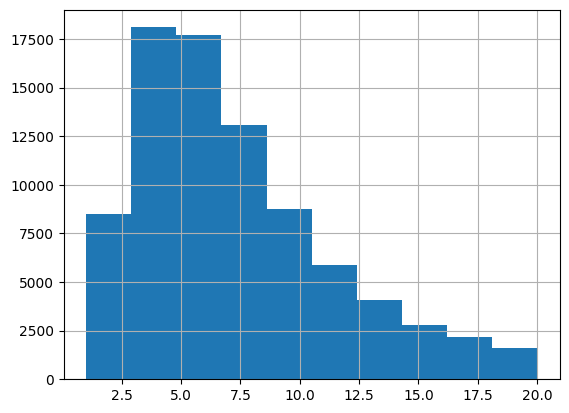

In [9]:
train_df.duration.hist()

In [10]:
train_df.duration.describe(percentiles=[0.95, 0.9, 0.75, 0.5])

count    82741.000000
mean         7.297055
std          4.107538
min          1.000000
50%          6.350000
75%          9.483333
90%         13.450000
95%         15.900000
max         20.000000
Name: duration, dtype: float64

In [11]:
train_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,distance,duration,hour_of_day,day_of_week
0,BC145343639B5E5B,classic_bike,2023-05-31 12:27:28,2023-05-31 12:38:36,Pershing Field,JC024,Newport PATH,JC066,40.742675,-74.051806,40.727224,-74.033759,member,2.294339,11.133333,12,2
1,A0CE41F47514FF5C,classic_bike,2023-05-01 18:12:37,2023-05-01 18:29:03,Pershing Field,JC024,Baldwin at Montgomery,JC020,40.742638,-74.051815,40.723659,-74.064194,casual,2.354073,16.433333,18,0
3,89AC48A5584B2DB4,classic_bike,2023-05-27 21:01:37,2023-05-27 21:13:16,Pershing Field,JC024,Manila & 1st,JC082,40.742677,-74.051789,40.721651,-74.042884,member,2.455469,11.650000,21,5
5,E5CB0D91D77D7ABC,classic_bike,2023-05-29 18:31:14,2023-05-29 18:36:40,Hilltop,JC019,Brunswick St,JC023,40.731169,-74.057574,40.724176,-74.050656,member,0.971745,5.433333,18,0
6,182ECD0410DCC11D,electric_bike,2023-05-07 12:30:42,2023-05-07 12:37:35,Hilltop,JC019,Hamilton Park,JC009,40.731169,-74.057574,40.727596,-74.044247,member,1.191130,6.883333,12,6


In [12]:


# haversine((40.757306457, -73.974517584), (40.7689738, -73.95482273), unit='km')

In [13]:
categorical = ['start_station_id', 'end_station_id', 'rideable_type', 'hour_of_day', 'day_of_week', 'start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual']
numerical = ['distance']

train_df[categorical] = train_df[categorical].astype(str)
val_df[categorical] = val_df[categorical].astype(str)

train_df['start_lat_lng'] = train_df['start_lat'] + '_' + train_df['start_lng']
train_df['end_lat_lng'] = train_df['end_lat'] + '_' + train_df['end_lng']
train_df['start_stop'] = train_df['start_station_id'] + '_' + train_df['end_station_id']
val_df['start_lat_lng'] = val_df['start_lat'] + '_' + val_df['start_lng']
val_df['end_lat_lng'] = val_df['end_lat'] + '_' + val_df['end_lng']
val_df['start_stop'] = val_df['start_station_id'] + '_' + val_df['end_station_id']

categorical = ['start_stop', 'rideable_type', 'hour_of_day', 'day_of_week', 'member_casual'] # 'start_station_id', 'end_station_id 'member_casual', 'hour_of_day', 'day_of_week', 'start_station_id', 'end_station_id' 'start_station_name', 'end_station_name', 'start_lat_lng', 'end_lat_lng'
numerical = ['distance']

train_dicts = train_df[categorical + numerical].to_dict(orient='records')
val_dicts = val_df[categorical + numerical].to_dict(orient='records')


dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

target = 'duration'

y_train = train_df[target].values
y_val = val_df[target].values

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [19]:
y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False).round(2)

2.72

/tmp/ipykernel_5368/2624495092.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')


/tmp/ipykernel_5368/2624495092.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_val, label='actual')


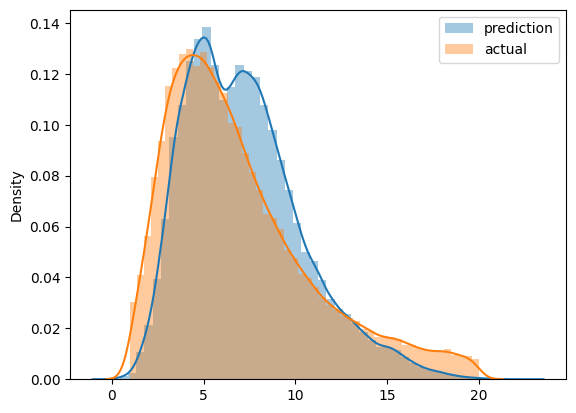

In [16]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_val, label='actual')

plt.legend()

/tmp/ipykernel_5368/2499170286.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['hour_of_day'])


<Axes: xlabel='hour_of_day', ylabel='Density'>

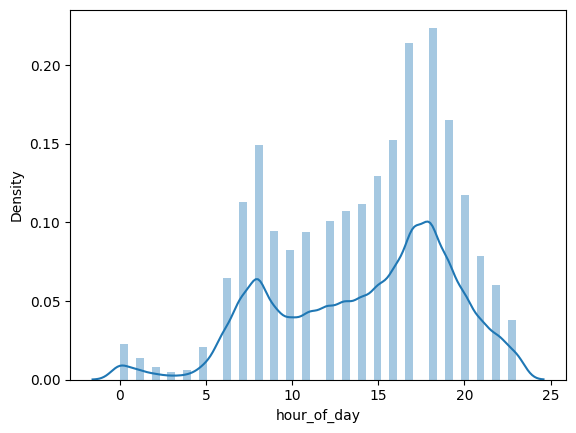

In [17]:
sns.distplot(train_df['hour_of_day'])

In [44]:
train_df['hour_of_day'].describe()

count     3289942
unique         19
top            17
freq       325040
Name: hour_of_day, dtype: object

In [170]:
df = pd.read_csv("./data/202305-citibike-tripdata.csv")
# https://s3.amazonaws.com/tripdata/index.html

/tmp/ipykernel_63030/3711102375.py:1: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/202305-citibike-tripdata.csv")


In [95]:
df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,176B188F3289F37B,classic_bike,2023-05-23 19:22:53,2023-05-23 19:35:23,E 50 St & Park Ave,6659.10,E 74 St & 1 Ave,6953.08,40.757306,-73.974518,40.768974,-73.954823,member
1,BB6957A02501C686,classic_bike,2023-05-27 08:49:55,2023-05-27 08:57:42,Flatbush Ave & Ocean Ave,3704.04,Grand Army Plaza & Plaza St West,4010.15,40.663657,-73.963014,40.672968,-73.970880,member
2,C67567E1DAFB9F2C,classic_bike,2023-05-12 20:19:58,2023-05-12 20:36:07,Flatbush Ave & Ocean Ave,3704.04,3 St & 7 Ave,3905.15,40.663657,-73.963014,40.670384,-73.978397,member
3,89DDFCEAE05D043A,electric_bike,2023-05-03 07:59:13,2023-05-03 08:07:04,Flatbush Ave & Ocean Ave,3704.04,3 St & 7 Ave,3905.15,40.663657,-73.963014,40.670384,-73.978397,member
4,63B1D5A7A2316252,classic_bike,2023-05-13 10:23:52,2023-05-13 10:47:17,Flatbush Ave & Ocean Ave,3704.04,Grand Army Plaza & Plaza St West,4010.15,40.663657,-73.963014,40.672968,-73.970880,member
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3580761,BA28157F10FA9C78,classic_bike,2023-05-11 17:37:54,2023-05-11 17:43:33,Lewis Ave & Fulton St,4196.01,Hancock St & Bedford Ave,4255.05,40.679739,-73.934619,40.682166,-73.953990,member
3580762,5FD57F3ED53FDBEB,classic_bike,2023-05-21 12:36:04,2023-05-21 13:19:32,35 Ave & 37 St,6563.12,5 Ave & E 78 St,7161.08,40.755733,-73.923661,40.776321,-73.964274,member
3580763,30CC35A9A433B701,classic_bike,2023-05-08 09:37:54,2023-05-08 10:04:59,Broadway & Berry St,5164.05,3 St & Prospect Park West,3865.05,40.710425,-73.965394,40.668132,-73.973638,member
3580764,2968C17CC49A7187,classic_bike,2023-05-27 19:55:19,2023-05-27 20:00:41,W 55 St & 6 Ave,6809.09,W 50 St & 9 Ave,6854.05,40.763189,-73.978434,40.763605,-73.989180,member


In [171]:
df.shape

(3580766, 13)

In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3580766 entries, 0 to 3580765
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 355.1+ MB


In [173]:
df.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual'],
      dtype='object')

In [174]:
df.isnull().sum()

ride_id                  0
rideable_type            0
started_at               0
ended_at                 0
start_station_name     570
start_station_id       570
end_station_name      8495
end_station_id        8495
start_lat                0
start_lng                0
end_lat               3009
end_lng               3009
member_casual            0
dtype: int64

In [175]:
df.dropna(inplace=True)

In [176]:
df = df[['ride_id', 'rideable_type', 'started_at', 'ended_at', 'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id', 'member_casual', 'start_lat', 'start_lng', 'end_lat', 'end_lng']]

In [177]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,member_casual,start_lat,start_lng,end_lat,end_lng
0,176B188F3289F37B,classic_bike,2023-05-23 19:22:53,2023-05-23 19:35:23,E 50 St & Park Ave,6659.10,E 74 St & 1 Ave,6953.08,member,40.757306,-73.974518,40.768974,-73.954823
1,BB6957A02501C686,classic_bike,2023-05-27 08:49:55,2023-05-27 08:57:42,Flatbush Ave & Ocean Ave,3704.04,Grand Army Plaza & Plaza St West,4010.15,member,40.663657,-73.963014,40.672968,-73.970880
2,C67567E1DAFB9F2C,classic_bike,2023-05-12 20:19:58,2023-05-12 20:36:07,Flatbush Ave & Ocean Ave,3704.04,3 St & 7 Ave,3905.15,member,40.663657,-73.963014,40.670384,-73.978397
3,89DDFCEAE05D043A,electric_bike,2023-05-03 07:59:13,2023-05-03 08:07:04,Flatbush Ave & Ocean Ave,3704.04,3 St & 7 Ave,3905.15,member,40.663657,-73.963014,40.670384,-73.978397
4,63B1D5A7A2316252,classic_bike,2023-05-13 10:23:52,2023-05-13 10:47:17,Flatbush Ave & Ocean Ave,3704.04,Grand Army Plaza & Plaza St West,4010.15,member,40.663657,-73.963014,40.672968,-73.970880


In [144]:
getDistanceFromLatLonInKm(40.757306, -73.974518, 40.768974, -73.954823)

2.10586830879352

In [9]:
# s_lat = 40.757306
# s_lng = -73.974518
# e_lat = 40.768974
# e_lng = -73.954823

# sine_part = sin(s_lat)*sin(e_lat)

# 3956 * round(acos(sine_part+cos(s_lat)*cos(e_lat)*cos(e_lng-s_lng)),8)

90.35816524

In [ ]:
# def find_distance(slat, elat, slng, elng):
    # sine_part = sin(slat)*sin(elat)
    

In [70]:
# df['distance'] = 3956 * acos(sin(df['start_lat'])*sin(df['end_lat'])+cos(df['start_lat'])*cos(df['end_lat'])*cos(df['start_lng']-df['end_lng']))  # kms 6371.0 miles 3956 df

TypeError: cannot convert the series to <class 'float'>

In [182]:
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

In [183]:
df['duration'] = df.ended_at - df.started_at
df.duration = df.duration.apply(lambda td: td.total_seconds()/60)

/tmp/ipykernel_63030/3426635498.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.duration)


<Axes: xlabel='duration', ylabel='Density'>

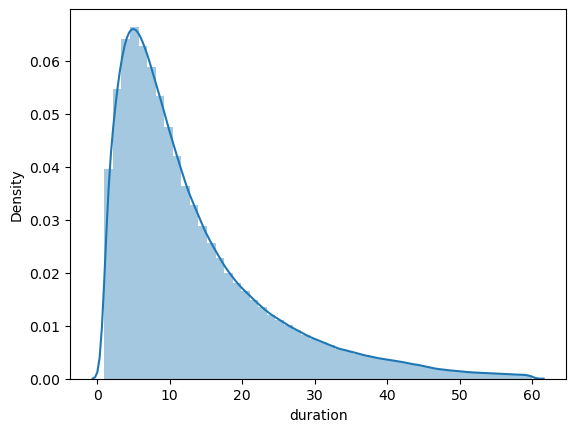

In [154]:
sns.distplot(df.duration)

In [184]:
df.duration.describe().round(2)
((df.duration >= 1) & (df.duration <= 60 )).mean()

0.9494041745433087

In [185]:
df = df[(df.duration >= 1) & (df.duration <= 60 )].copy()
df['hour_of_day'] = df.started_at.dt.hour

In [153]:
df

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,start_lat,start_lng,end_lat,end_lng,distance,duration,hour_of_day
0,176B188F3289F37B,classic_bike,2023-05-23 19:22:53,2023-05-23 19:35:23,E 50 St & Park Ave,E 74 St & 1 Ave,member,40.757306,-73.974518,40.768974,-73.954823,2.105814,12.500000,19
1,BB6957A02501C686,classic_bike,2023-05-27 08:49:55,2023-05-27 08:57:42,Flatbush Ave & Ocean Ave,Grand Army Plaza & Plaza St West,member,40.663657,-73.963014,40.672968,-73.970880,1.229639,7.783333,8
2,C67567E1DAFB9F2C,classic_bike,2023-05-12 20:19:58,2023-05-12 20:36:07,Flatbush Ave & Ocean Ave,3 St & 7 Ave,member,40.663657,-73.963014,40.670384,-73.978397,1.497586,16.150000,20
3,89DDFCEAE05D043A,electric_bike,2023-05-03 07:59:13,2023-05-03 08:07:04,Flatbush Ave & Ocean Ave,3 St & 7 Ave,member,40.663657,-73.963014,40.670384,-73.978397,1.497586,7.850000,7
4,63B1D5A7A2316252,classic_bike,2023-05-13 10:23:52,2023-05-13 10:47:17,Flatbush Ave & Ocean Ave,Grand Army Plaza & Plaza St West,member,40.663657,-73.963014,40.672968,-73.970880,1.229639,23.416667,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3580761,BA28157F10FA9C78,classic_bike,2023-05-11 17:37:54,2023-05-11 17:43:33,Lewis Ave & Fulton St,Hancock St & Bedford Ave,member,40.679739,-73.934619,40.682166,-73.953990,1.655644,5.650000,17
3580762,5FD57F3ED53FDBEB,classic_bike,2023-05-21 12:36:04,2023-05-21 13:19:32,35 Ave & 37 St,5 Ave & E 78 St,member,40.755733,-73.923661,40.776321,-73.964274,4.115773,43.466667,12
3580763,30CC35A9A433B701,classic_bike,2023-05-08 09:37:54,2023-05-08 10:04:59,Broadway & Berry St,3 St & Prospect Park West,member,40.710425,-73.965394,40.668132,-73.973638,4.753853,27.083333,9
3580764,2968C17CC49A7187,classic_bike,2023-05-27 19:55:19,2023-05-27 20:00:41,W 55 St & 6 Ave,W 50 St & 9 Ave,member,40.763189,-73.978434,40.763605,-73.989180,0.906177,5.366667,19


In [169]:
df.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'end_station_name', 'member_casual', 'start_lat',
       'start_lng', 'end_lat', 'end_lng', 'distance', 'duration',
       'hour_of_day'],
      dtype='object')

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3580766 entries, 0 to 3580765
Data columns (total 14 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
 13  duration            float64       
dtypes: datetime64[ns](2), float64(5), object(7)
memory usage: 382.5+ MB


0.9494041745433087

In [23]:
# categorical = ['start_station_name', 'end_station_name', 'rideable_type', 'member_casual', 'hour_of_day'] #'start_station_id', 'end_station_id',
# numerical = ['trip_distance']
# df[categorical] = df[categorical].astype(str)

In [187]:
train_dicts = df[categorical+numerical].to_dict(orient='records')

In [188]:
train_dicts = df[categorical+numerical].to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'

y_train=df[target].values

In [189]:
len(dv.feature_names_)

3838

In [190]:
target = 'duration'

In [191]:
y_train=df[target].values

In [192]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [199]:
lr = Lasso(0.1)
lr.fit(X_train, y_train)

Lasso(alpha=0.1)

In [200]:
y_pred = lr.predict(X_train)

/tmp/ipykernel_63030/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')


/tmp/ipykernel_63030/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


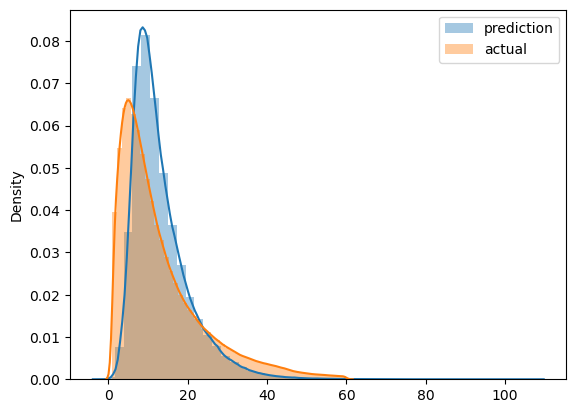

In [167]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [201]:
mean_squared_error(y_train, y_pred, squared=False).round(2)

8.32

In [86]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration,hour_of_day
0,176B188F3289F37B,classic_bike,2023-05-23 19:22:53,2023-05-23 19:35:23,E 50 St & Park Ave,6659.10,E 74 St & 1 Ave,6953.08,40.757306,-73.974518,40.768974,-73.954823,member,12.500000,19
1,BB6957A02501C686,classic_bike,2023-05-27 08:49:55,2023-05-27 08:57:42,Flatbush Ave & Ocean Ave,3704.04,Grand Army Plaza & Plaza St West,4010.15,40.663657,-73.963014,40.672968,-73.970880,member,7.783333,8
2,C67567E1DAFB9F2C,classic_bike,2023-05-12 20:19:58,2023-05-12 20:36:07,Flatbush Ave & Ocean Ave,3704.04,3 St & 7 Ave,3905.15,40.663657,-73.963014,40.670384,-73.978397,member,16.150000,20
3,89DDFCEAE05D043A,electric_bike,2023-05-03 07:59:13,2023-05-03 08:07:04,Flatbush Ave & Ocean Ave,3704.04,3 St & 7 Ave,3905.15,40.663657,-73.963014,40.670384,-73.978397,member,7.850000,7
4,63B1D5A7A2316252,classic_bike,2023-05-13 10:23:52,2023-05-13 10:47:17,Flatbush Ave & Ocean Ave,3704.04,Grand Army Plaza & Plaza St West,4010.15,40.663657,-73.963014,40.672968,-73.970880,member,23.416667,10


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3393303 entries, 0 to 3580765
Data columns (total 15 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
 13  duration            float64       
 14  hour_of_day         object        
dtypes: datetime64[ns](2), float64(5), object(8)
memory usage: 414.2+ MB


In [88]:
df.shape

(3393303, 15)